## SETUP(반드시 실행해주세요)

In [1]:
# install gridworld from pip
!pip install dezerogym

## 밑에 그림과 같은 그리드 월드를 구축해서 상태전이함수가 필요없는 결정적 환경과 상태전이함수가 존재하는 확률적 환경에서 가치반복법과 정책반복법을 구현해보겠습니다.**(읽고 코드 진행해주세요)**

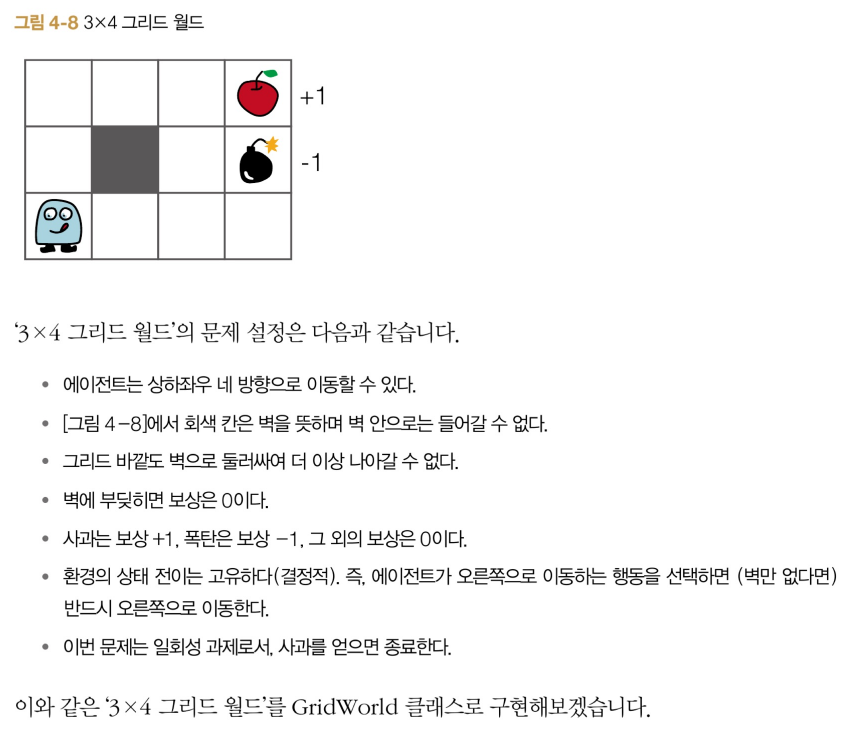

## 결정론적 환경에서 구현하기(상태전이함수가 존재하지 않음)

### 그리드 월드 구축

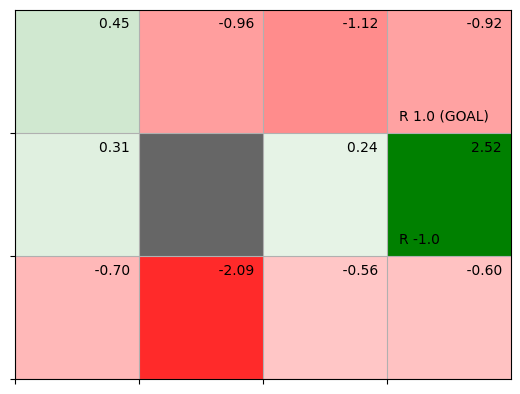

In [2]:
import numpy as np
from dezerogym.gridworld import GridWorld

env = GridWorld()
V = {}
for state in env.states():
    V[state] = np.random.randn()
env.render_v(V)

### 정책 반복법

#### 정책 평가

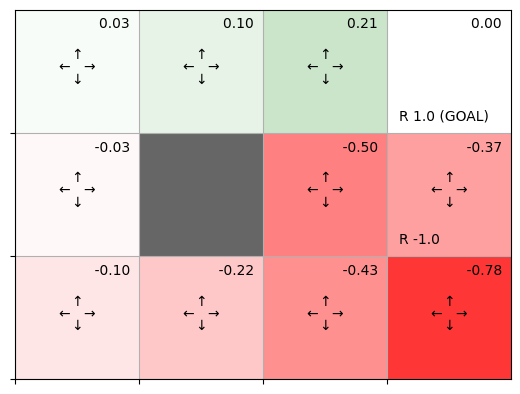

In [3]:
from collections import defaultdict
from dezerogym.gridworld import GridWorld


def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_probs = pi[state]
        new_V = 0
        for action, action_prob in action_probs.items():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            new_V += action_prob * (r + gamma * V[next_state])
        V[state] = new_V
    return V


def policy_eval(pi, V, env, gamma, threshold=0.001):
    while True:
        old_V = V.copy()
        V = eval_onestep(pi, V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        if delta < threshold:
            break
    return V


env = GridWorld()
gamma = 0.9

pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

#### 정책 반복(정책 평가와 정책 개선 반복)

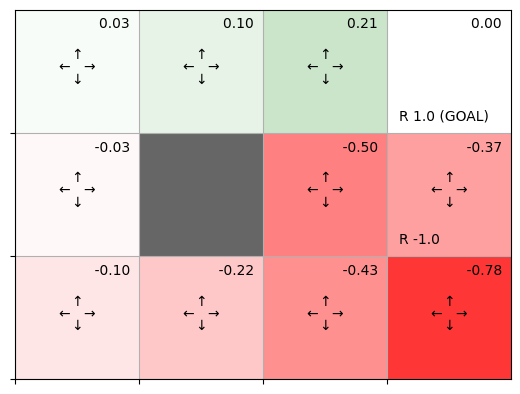

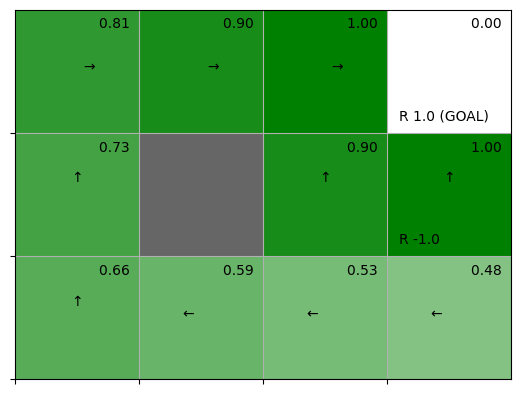

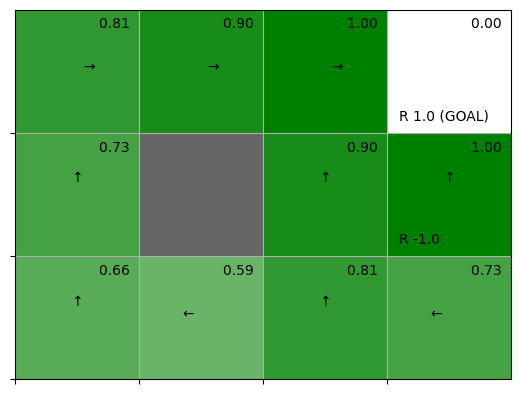

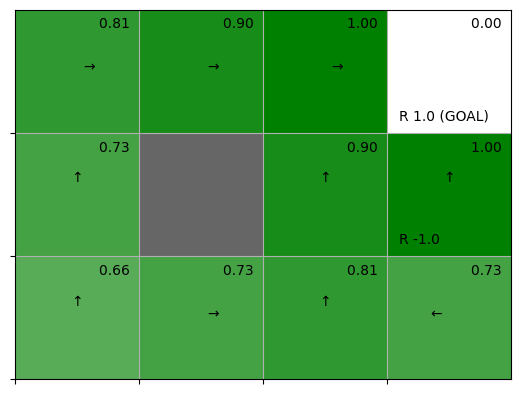

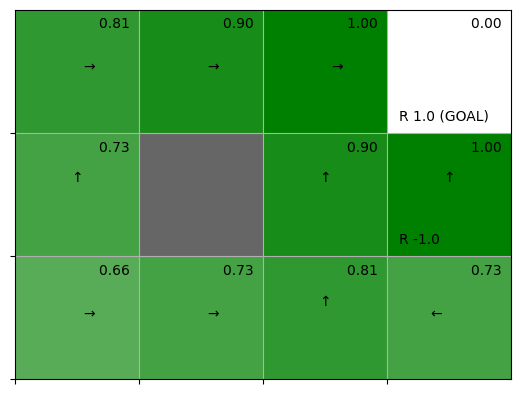

In [4]:
def argmax(d):
    """d (dict)"""
    max_value = max(d.values())
    max_key = -1
    for key, value in d.items():
        if value == max_value:
            max_key = key
    return max_key

# 정책 개선
def greedy_policy(V, env, gamma):
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value

        max_action = argmax(action_values)
        action_probs = {0: 0, 1: 0, 2: 0, 3: 0}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi


def policy_iter(env, gamma, threshold=0.001, is_render=True):
    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
    V = defaultdict(lambda: 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold)
        new_pi = greedy_policy(V, env, gamma)

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi:
            break
        pi = new_pi

    return pi


env = GridWorld()
gamma = 0.9
pi = policy_iter(env, gamma)


### 가치반복법

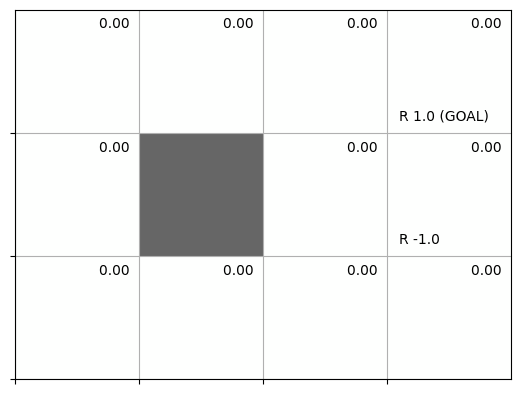

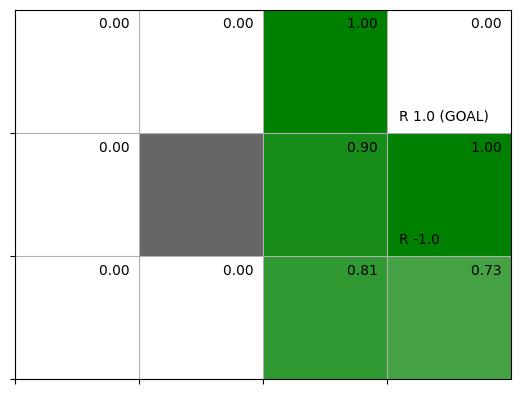

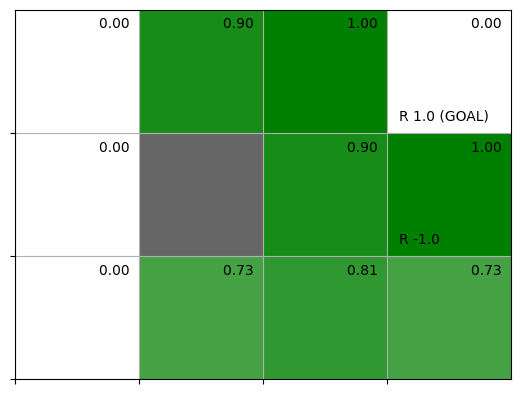

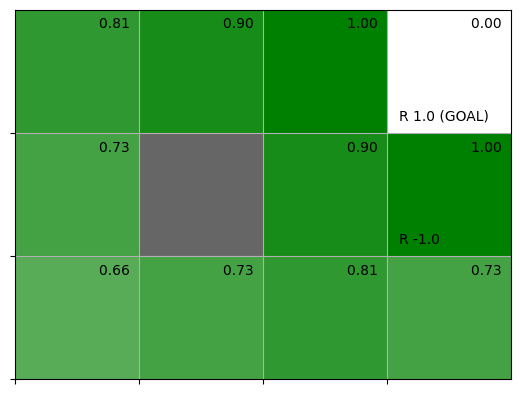

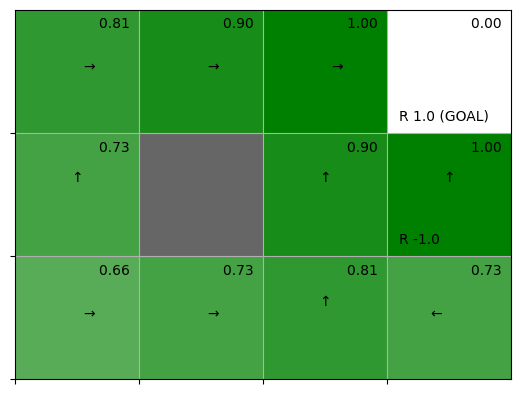

In [5]:
def value_iter_onestep(V, env, gamma):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_values = []
        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values.append(value)
        #각 행동 중에 가장 큰 가치함수를 V(s)로 선택
        V[state] = max(action_values)
    return V


def value_iter(V, env, gamma, threshold=0.001, is_render=True):
    while True:
        if is_render:
            env.render_v(V)

        old_V = V.copy()
        V = value_iter_onestep(V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        if delta < threshold:
            break
    return V


V = defaultdict(lambda: 0)
env = GridWorld()
gamma = 0.9

V = value_iter(V, env, gamma)

pi = greedy_policy(V, env, gamma)
env.render_v(V, pi)

## 확률적 환경에서 구현하기(상태전이함수가 존재함)

### 라이브러리 구축 ** **그대로 실행해주세요** **

In [6]:
!pip install gymnasium
!pip install gym-gridworlds

In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.registration import register

### 환경 설정 ** **그대로 실행해주세요** **

In [8]:
# 방향 인덱스
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
ACTIONS = [UP, RIGHT, DOWN, LEFT]
DIR2DELTA = {UP: (-1, 0), RIGHT: (0, 1), DOWN: (1, 0), LEFT: (0, -1)}

class GridWorld3x4(gym.Env):
    metadata = {"render_modes": ["ansi"]}

    def __init__(self, noise: float = 0.2, step_reward: float = 0.0, render_mode=None):
        super().__init__()
        self.H, self.W = 3, 4
        self.noise = float(noise)
        self.step_reward = float(step_reward)
        self.render_mode = render_mode
        #좌표 하한값과 상한값 설정 (0,0)부터 (2,3)까지
        self.observation_space = spaces.Box(low=np.array([0, 0]),
                                            high=np.array([self.H - 1, self.W - 1]),
                                            shape=(2,), dtype=np.int32)
        self.action_space = spaces.Discrete(4)

        # 맵 구성
        self.wall  = (1, 1)          # 회색 벽
        self.start = (2, 0)          # 시작 위치
        self.goal  = (0, 3)          # 사과 (+1)
        self.bomb  = (1, 3)          # 폭탄 (−1)
        self.terminal_rewards = {self.goal: 1.0} #사과에 도착하면 종료
        self.s = None

    # ---------- Gymnasium 필수 메서드 ----------

    # 환경 초기화, 시작점으로 이동합니다.
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.s = self.start
        return np.array(self.s, dtype=np.int32), {}

    # ---------- 내부 유틸 ----------
    def _move(self, s, a):
        r, c = s
        dr, dc = DIR2DELTA[a]
        nr, nc = r + dr, c + dc
        if nr < 0 or nr >= self.H or nc < 0 or nc >= self.W or (nr, nc) == self.wall:
            return (r, c)       # 막히면 제자리
        return (nr, nc)

    # 사과가 위치해있는 곳에 도착하면 True를 반환
    # self.terminal_rewards는 이런 형태입니다 : {(0,3): 1.0}
    def _is_terminal(self, s):      return s in self.terminal_rewards

    # 사과가 위치해있는 곳에 도착하면 reward 1과 True를 튜플 형태로 반환, 아니면 reward 0과 False를 튜플 형태로 반환
    def _reward_done(self, s):
        if s in self.terminal_rewards:  return self.terminal_rewards[s], True
        return 0.0, False

    # ---------- 확률적 상태 전이 ----------

    #특정 상태에서 상태전이확률리스트(probs)와 각 행동에 따른 좌표리스트(nexts) 출력
    def _transition_candidates(self, s, a):
        intended = a
        # left는 현재 행동에 대해서 반시계방향으로 90도 회전했을 때 방향이고 right는 현재 행동에 대해서 시계방향으로 90도 회전했을 때 방향입니다.
        left     = (a - 1) % 4
        right    = (a + 1) % 4
        probs  = np.array([1.0 - self.noise, self.noise / 2, self.noise / 2])
        nexts  = [self._move(s, d) for d in (intended, left, right)]
        return probs, nexts

    # 현재상태와 행동을 기반으로 다음상태 출력
    def get_transitions(self, s, a):
        #1)  사과가 있는 곳에 도착했으면 확률 1.0으로 '자기 자신'으로 머물고 보상·종료 표시만 되돌려준다.
        if self._is_terminal(s):
            return [(1.0, s, 0.0, True)]
        # 2) 사과가 있는 곳에 도착하지 않았으면 현재 상태·행동에 대한 (확률 배열 probs, 후보 다음 상태 nexts) 를 얻는다.
        probs, nexts = self._transition_candidates(s, a)
        outs = []
        # 3) 각 후보(nexts)와 그 확률(probs)을 한 쌍씩 순회
        for p, ns in zip(probs, nexts):
            r, done = self._reward_done(ns)
            if not done:
                r += self.step_reward
            outs.append((p, ns, r, done))
        # 4) [(p1, s1', r1, done1), (p2, s2', r2, done2), ...] 형태로 반환
        return outs


    def step(self, action: int):
        assert self.action_space.contains(action)
        if self._is_terminal(self.s):
            return np.array(self.s, dtype=np.int32), 0.0, True, False, {}

        probs, nexts = self._transition_candidates(self.s, action)
        ns = self.np_random.choice(nexts, p=probs)
        reward, terminated = self._reward_done(ns)
        if not terminated:
            reward += self.step_reward
        self.s = ns
        return np.array(ns, dtype=np.int32), float(reward), bool(terminated), False, {}

    #grid에 시각화하기 위한 함수
    def render(self):
        grid = [["." for _ in range(self.W)] for _ in range(self.H)]
        wr, wc = self.wall;  grid[wr][wc] = "벽"
        gr, gc = self.goal;  grid[gr][gc] = "사과"
        br, bc = self.bomb;  grid[br][bc] = "폭탄"
        ar, ac = self.s;     grid[ar][ac] = "@"
        print("\n".join(" ".join(row) for row in grid))

    # ---------- 확률적 상태 전이 ----------
    def get_transitions(self, s, a):
        if self._is_terminal(s):
            return [(1.0, s, 0.0, True)]
        probs, nexts = self._transition_candidates(s, a)
        outs = []
        for p, ns in zip(probs, nexts):
            r, done = self._reward_done(ns)
            if not done:
                r += self.step_reward
            outs.append((p, ns, r, done))
        return outs

    #특정 상태에서 상태전이확률리스트(probs)와 각 행동에 따른 좌표리스트(nexts) 출력
    def _transition_candidates(self, s, a):
        intended = a
        # left는 현재 행동에 대해서 반시계방향으로 90도 회전했을 때 방향이고 right는 현재 행동에 대해서 시계방향으로 90도 회전했을 때 방향입니다.
        left     = (a - 1) % 4
        right    = (a + 1) % 4
        probs  = np.array([1.0 - self.noise, self.noise / 2, self.noise / 2])
        nexts  = [self._move(s, d) for d in (intended, left, right)]
        return probs, nexts


# Gymnasium 등록
register(id="custom/GridWorld3x4Stochastic-v0", entry_point=GridWorld3x4)


In [9]:
# 모든 state의 좌표값 표시해주는 리스트 *벽 제외* ex) [(0,0),(0,1)...]
def states(env):
    ue = env.unwrapped
    S = []
    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) != ue.wall:
                S.append((r, c))
    return S

### 가치 반복(value iteration)

In [10]:
def value_iteration(env, gamma=0.9, tol=1e-3, max_iter=10_000):
    ue = env.unwrapped
    V  = defaultdict(float) # 상태 가치 V(s) : 초기값 0.0
    S  = states(env)

    for _ in range(max_iter):
      delta = 0.0                          # 이번 iteration에서 최대 변화량 초기화

      for s in S:                          # 모든 상태 순회
        # --- v_new 계산 ---
        if ue._is_terminal(s):           # 1) 사과가 있는 위치에 도착한 상태인지 먼저 확인
            v_new = 0.0                  #    사과 위치에 도달했으면 V(s)=0 으로 정의
        else:                            # 2) 사과 위치에 도달하지 않았으면 Bellman 최적 방정식 계산
            best_q = float("-inf")       #    Q 값 최대치를 찾기 위한 변수
            for a in ACTIONS:            #    모든 행동에 대해
                q_sa = 0.0
                # not done은 사과에 도달했으면 0, 사과에 도달하지 않았으면 1으로 간주
                for p, ns, r, done in ue.get_transitions(s, a):
                    # 벨만 최적 방정식: Q(s,a) = Σ p(s'|s,a) [r + γ V(s')]
                    q_sa += p * (r + gamma * V[ns] * (not done))
                if q_sa > best_q:        #   최대 Q(s,a)를 추적
                    best_q = q_sa
            v_new = best_q               #    V(s) ← max_a Q(s,a)

        # --- δ(변화량) 업데이트 ---
        diff   = abs(v_new - V[s])       # |V_new - V_old|
        if diff > delta:                 # 현재까지의 최대 변화량보다 크면 교체
            delta = diff

        # --- 가치 함수 업데이트 ---
        V[s] = v_new

    # --- 수렴 검사 ---
      if delta < tol:                      # 모든 상태의 변화가 허용 오차보다 작아지면
          break                           # 반복 종료(수렴)

    # 정책 추출: 각 상태별로 행동별 Q값 dict 반환
    pi = {}
    for s in S:
        if ue._is_terminal(s):
            pi[s] = None
        else:
            q_dict = {}
            for a in ACTIONS:
                q_sa = 0.0
                for p, ns, r, done in ue.get_transitions(s, a):
                    # 벨만 최적 방정식: Q(s,a) = Σ p(s'|s,a) [r + γ V(s')]
                    q_sa += p * (r + gamma * V[ns] * (not done))
                q_dict[a] = q_sa # 행동 a의 Q값 저장
            pi[s] = q_dict # 상태 s의 정책(행동별 Q값 dict) 저장
    return V, pi

### 정책 반복

#### 정책 평가

In [11]:
from collections import defaultdict
import numpy as np

def policy_evaluation(env, pi, gamma=0.9, tol=1e-3, max_iter=10_000):
    ue = env.unwrapped
    V  = defaultdict(float)       # V(s) 초기값 0
    S  = states(env)              # 모든 상태 집합

    for _ in range(max_iter):
        delta = 0.0               # 한 번의 iteration에서 최대 변화량

        for s in S:               # 모든 상태를 순회
            # 1) v_new 계산 ----------------------------
            if ue._is_terminal(s):          # 사과 위치에 도달한 상태면
                v_new = 0.0                 #   가치 = 0
            else:                           # 사과 위치에 도달한 상태가 아니면
                v_new = 0.0                 #   π(s)의 기대값 누적 변수
                acts = pi.get(s, None)      #   정책이 없는 상태 예외 처리
                if acts is None:
                    continue                #   정책이 없는 상태는 건너뜀
                for a, pa in acts.items():  #   정책이 주는 (행동, 확률) 쌍
                    if pa == 0.0:
                        continue            #   확률 0인 행동은 건너뜀
                    q_sa = 0.0              #   Qπ(s,a) 누적 변수
                    for p, ns, r, done in ue.get_transitions(s, a):
                        #   한 스텝 기대보상 r + gamma * V(ns)
                        # not done은 사과에 도달했으면 0, 사과에 도달하지 않았으면 1으로 간주
                        q_sa += p * (r + gamma * V[ns] * (not done))
                    v_new += pa * q_sa      #   행동 확률 pa 로 가중합
            # ------------------------------------------

            # 2) 변화량(δ) 업데이트 -----------------------
            if not np.isfinite(v_new):
                v_new = 0.0                 #   오버플로우/NaN 방지
            diff = abs(v_new - V[s])
            if diff > delta:
                delta = diff
            # ------------------------------------------

            # 3) 가치 함수 갱신 --------------------------
            V[s] = v_new
            # ------------------------------------------

        # 4) 수렴 검사 ---------------------------------
        if delta < tol:
            break                            # 허용 오차 이내면 종료
        # ----------------------------------------------

    return V                                  # V^π



#### 정책 개선(policy improvement)

In [12]:
from collections import defaultdict
import numpy as np

# ------------------------------------------------------------
# (1) policy_improvement :  V가 주어졌을 때 greedy 정책 π_new 생성
# ------------------------------------------------------------
def policy_improvement(env, V, gamma=0.9):
    ue = env.unwrapped                 # 원본 환경
    # π_new[s] = {a:prob} 구조, 처음엔 모든 확률 0
    pi_new = defaultdict(lambda: {a: 0.0 for a in ACTIONS})

    # 모든 상태 순회
    for s in states(env):
        if ue._is_terminal(s):         # 터미널이면 정책 불필요
            continue

        # ---------- Q(s,a) 중 최대값(=최적 행동) 찾기 ----------
        best_q = float("-inf")        # 최대 Q tracked 변수
        best_a = None                  # 최대 Q를 주는 행동

        for a in ACTIONS:              # 4개 행동 모두 조사
            q_sa = 0.0                 # Qπ(s,a) 누적 변수
            for p, ns, r, done in ue.get_transitions(s, a):
                # 확률 p(상태전이확률) 가중합
                q_sa += p * (r + gamma * V[ns] * (not done))
            # 최대 Q값 및 행동 업데이트
            if not np.isfinite(q_sa):
                q_sa = -1e9            # 오버플로우/NaN 방지
            if q_sa > best_q:
                best_q = q_sa
                best_a = a
        # ------------------------------------------------------

        # best_a를 확률 1.0로 지정(결정론적 greedy 정책)
        for a in ACTIONS:
            pi_new[s][a] = 1.0 if a == best_a else 0.0

    return pi_new


#### 정책 반복법(정책 평가와 정책 개선 반복)

In [13]:
from collections import defaultdict

def policy_iteration(env, gamma=0.9, tol=1e-3, max_eval_iter=10_000):
    # (a) 초기 정책 : 모든 행동을 동일 확률로 선택
    pi = defaultdict(lambda: {a: 1.0 / len(ACTIONS) for a in ACTIONS})

    # (b) 반복
    while True:
        # 1) 정책 평가 : 현재 π에 대한 가치 V^π 계산
        V = policy_evaluation(env, pi,
                             gamma=gamma,
                             tol=tol,
                             max_iter=max_eval_iter)

        # 2) 정책 개선 : V를 이용해 greedy 정책 π' 생성
        new_pi = policy_improvement(env, V, gamma=gamma)

        # 3) 정책이 변했는지(수렴 여부) 검사
        policies_equal = True                 # 두 정책이 동일한지 플래그
        for s in states(env):
            acts1 = pi.get(s, {})
            acts2 = new_pi.get(s, {})
            for a in ACTIONS:
                # float 오차 허용 (정확히 0/1이 아닐 수 있음)
                if abs(acts1.get(a, 0.0) - acts2.get(a, 0.0)) > 1e-8:
                    policies_equal = False
                    break
            if not policies_equal:
                break

        if policies_equal:                    # 더 이상 개선되지 않으면 종료
            return V, new_pi

        # 4) 개선된 정책으로 다음 루프
        pi = new_pi



### 가치반복법과 정책반복법 시각화

In [14]:
def visualize_policy(pi, env):
    ue = env.unwrapped
    grid = [[" " for _ in range(ue.W)] for _ in range(ue.H)]

    action_symbols = {UP: "↑", RIGHT: "→", DOWN: "↓", LEFT: "←"}

    for r in range(ue.H):
        for c in range(ue.W):
            s = (r, c)
            if s == ue.wall:
                grid[r][c] = "#"
            elif s in ue.terminal_rewards:
                val = ue.terminal_rewards[s]
                grid[r][c] = "A" if val > 0 else "B"
            elif s in pi:
                acts = pi[s]
                max_act = max(acts, key=acts.get)
                grid[r][c] = action_symbols.get(max_act, "?")
            else:
                grid[r][c] = "?"

    # 그리드 출력
    for row in grid:
        print(" ".join(row))


#### 가치반복법 시각화

In [15]:
# 환경 인스턴스 생성
env = gym.make("custom/GridWorld3x4Stochastic-v0", noise=0.2)

# 가치 반복
V_vi, pi_vi = value_iteration(env)

# 결과 출력
def pretty(V):
    ue = env.unwrapped
    M = np.full((ue.H, ue.W), np.nan)
    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) != ue.wall:
                M[r, c] = V[(r, c)]
    return np.round(M, 2)

print("Value Iteration V:")
print(pretty(V_vi))
print("\nValue Iteration Policy:")
visualize_policy(pi_vi, env)

Value Iteration V:
[[0.73 0.85 0.96 0.  ]
 [0.64  nan 0.86 0.96]
 [0.59 0.66 0.75 0.84]]

Value Iteration Policy:
→ → → A
↑ # ↑ ↑
→ → ↑ ↑


In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def plot_value_policy_grid(V, pi, env):
    """
    값 함수와 정책(방향)을 그리드로 시각화
    """
    ue = env.unwrapped
    grid_vals = np.full((ue.H, ue.W), np.nan)
    grid_dirs = np.full((ue.H, ue.W), '', dtype=object)

    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) == ue.wall:
                continue
            grid_vals[r, c] = V.get((r, c), np.nan)
            if (r, c) in pi:
                acts = pi[(r, c)]
                if acts is not None:
                    best_a = max(acts, key=acts.get)
                    dir_symbol = {0:'↑', 1:'→', 2:'↓', 3:'←'}.get(best_a, '')
                    grid_dirs[r, c] = dir_symbol

    # 색상 맵: 빨강(낮음)→초록(높음)
    colors = [(1,0,0), (1,1,1), (0,1,0)]  # red→white→green
    cmap = LinearSegmentedColormap.from_list('rwg', colors)

    fig, ax = plt.subplots(figsize=(7,6), dpi=120)
    im = ax.imshow(grid_vals, cmap=cmap, vmin=np.nanmin(grid_vals), vmax=np.nanmax(grid_vals))

    ax.set_xticks(np.arange(ue.W))
    ax.set_yticks(np.arange(ue.H))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='minor', color='black', linewidth=3)
    ax.tick_params(which='minor', bottom=False, left=False)

    # 값과 방향 텍스트 삽입
    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) == ue.wall:
                ax.text(c, r, '#', ha='center', va='center', color='black', fontsize=24, weight='bold')
            else:
                if not np.isnan(grid_vals[r, c]):
                    ax.text(c, r-0.2, f'{grid_vals[r, c]:.2f}', ha='center', va='center', color='black', fontsize=14)
                ax.text(c, r+0.2, grid_dirs[r, c], ha='center', va='center', color='black', fontsize=22)

    plt.title('Value Function and Policy Directions', pad=20)
    plt.tight_layout(pad=3)
    plt.gca().invert_yaxis()
    plt.show()

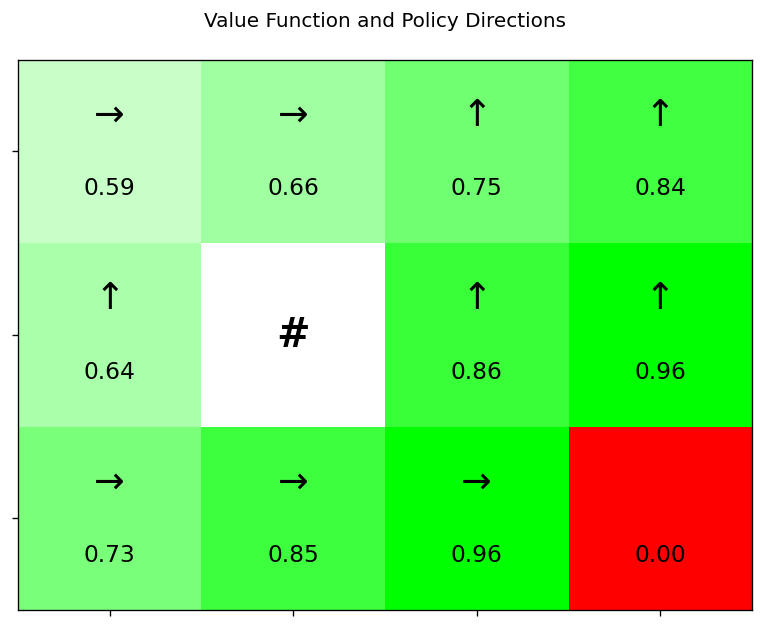

In [17]:
plot_value_policy_grid(V_vi, pi_vi,env)

#### 정책 반복법 시각화

In [18]:
# 환경 인스턴스 생성
env = gym.make("custom/GridWorld3x4Stochastic-v0", noise=0.2)

# 정책 반복
V_pi, pi_pi = policy_iteration(env)


# 결과 출력
def pretty(V):
    ue = env.unwrapped
    M = np.full((ue.H, ue.W), np.nan)
    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) != ue.wall:
                M[r, c] = V[(r, c)]
    return np.round(M, 2)


print("\nPolicy Iteration V:")
print(pretty(V_pi))
print("\nPolicy Iteration Policy:")
visualize_policy(pi_pi, env)



Policy Iteration V:
[[0.73 0.85 0.96 0.  ]
 [0.64  nan 0.86 0.96]
 [0.59 0.66 0.75 0.84]]

Policy Iteration Policy:
→ → → A
↑ # ↑ ↑
→ → ↑ ↑


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def plot_value_policy_grid(V, pi, env):
    ue = env.unwrapped
    grid_vals = np.full((ue.H, ue.W), np.nan)
    grid_dirs = np.full((ue.H, ue.W), '', dtype=object)

    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) == ue.wall:
                continue
            grid_vals[r, c] = V.get((r, c), np.nan)
            if (r, c) in pi:
                acts = pi[(r, c)]
                best_a = max(acts, key=acts.get)
                dir_symbol = {0:'↑', 1:'→', 2:'↓', 3:'←'}.get(best_a, '')
                grid_dirs[r, c] = dir_symbol

    # 색상 맵: 빨강(낮음)→초록(높음)
    colors = [(1,0,0), (1,1,1), (0,1,0)]  # red→white→green
    cmap = LinearSegmentedColormap.from_list('rwg', colors)

    fig, ax = plt.subplots(figsize=(7,6), dpi=120)  # 크기와 해상도 증가
    im = ax.imshow(grid_vals, cmap=cmap, vmin=np.nanmin(grid_vals), vmax=np.nanmax(grid_vals))

    ax.set_xticks(np.arange(ue.W))
    ax.set_yticks(np.arange(ue.H))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='minor', color='black', linewidth=3)  # 격자 외곽 강조
    ax.tick_params(which='minor', bottom=False, left=False)  # 틱 숨기기

    # 값과 방향 텍스트 삽입 (위치 조정)
    for r in range(ue.H):
        for c in range(ue.W):
            if (r, c) == ue.wall:
                ax.text(c, r, '#', ha='center', va='center', color='black', fontsize=24, weight='bold')
            else:
                if not np.isnan(grid_vals[r, c]):
                    ax.text(c, r-0.2, f'{grid_vals[r, c]:.2f}', ha='center', va='center', color='black', fontsize=14)
                ax.text(c, r+0.2, grid_dirs[r, c], ha='center', va='center', color='black', fontsize=22)

    plt.title('Value Function and Policy Directions', pad=20)  # 제목 여백 추가
    plt.tight_layout(pad=3)  # 전체 여백 증가
    plt.gca().invert_yaxis()
    plt.show()


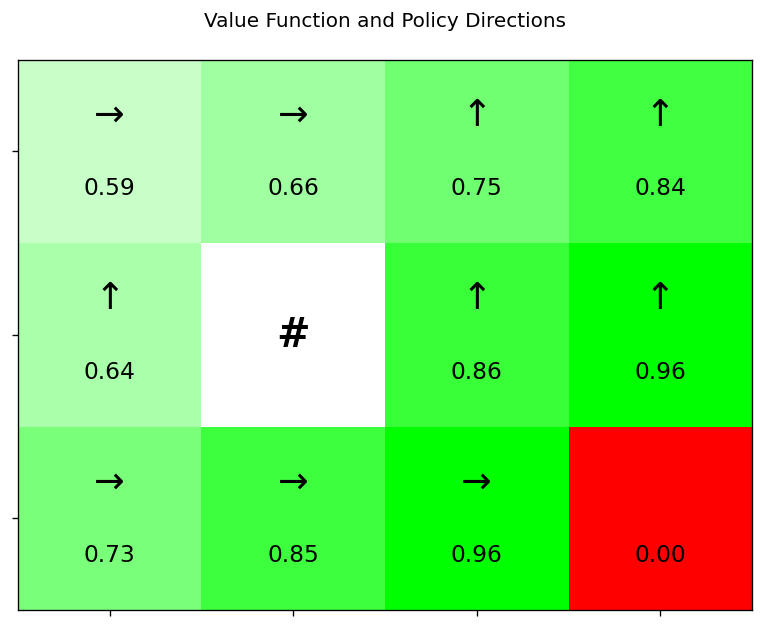

In [20]:
plot_value_policy_grid(V_pi, pi_pi,env)

## 문제

### 1. 코드상에서 가치 반복법의 매 iteration마다 각 state에서 정책개선이 일어나고있는지 확인해주세요. 그리고 정책개선이 있으면 있는 이유, 없으면 없는 이유를 말해주세요.

정책 개선이 매 iteration마다 일어나고 있다. 각 상태에서 V[s]를 갱신할 때마다 가장 좋은 행동 (max_a) 을 선택하는 과정에서 가치 평가와 정책 개선이 동시에 진행된다. 매 iteration마다 max_a를 취하면서 사실상 현재 V를 기준으로 한 greedy 정책으로의 개선이 동시에 이루어지고 있다.

### 2. 정책반복법 코드 상에서 결정론적 환경과 확률적 환경의 각 상태별 행동이 결정적인지 아닌지를 판별해주세요

정책은 항상 결정론적이다. policy_improvement() 부분에서 best_a 하나만 선택되고 그 확률이 1.0으로 설정되면서 나머지 행동은 전부 0.0이기 때문이다. 환경이 확률적이라도 정책 자체는 결정적일 수 있으므로 생성된 정책은 결정론적이다.